# log-Euler scheme

As the explicit Euler scheme involves Gaussian increments, the discretized diffusion of $x$ can take values from $-\infty$ to $+\infty$. However we have shown that the real diffusion $x$ is bounded from below by $- \frac{a(t)}{b(t)}, \ \forall t \ge 0$. To reproduce an approximation of $x$ which satisfies this condition on can implement the so called **log-Euler scheme**.

The method consists in applying the Euler scheme on an invertible transformation of $x$. 
Let $x(t) = f(u(t))$ such that $\forall t, f(u(t)) \ge - \frac{a(t)}{b(t)}$. 

For instance, $$x(t) = e^{u(t)} - \frac{a(t)}{b(t)}. \quad \iff u(t) = \ln \big( x(t) + \frac{a(t)}{b(t)}\big)$$

If $$\mathrm{d}x(t) = \mu(t,x(t)) \mathrm{d}t + \sigma(t,x(t)) \ \mathrm{d}W_t$$, one has by Itô's lemma:

$$\begin{array}{ll} \mathrm{d}u(t) &= \frac{\big(\frac{a(t)}{b(t)}\big)'}{x(t) + \frac{a(t)}{b(t)}} \ \mathrm{d}t + \frac{1}{x(t) + \frac{a(t)}{b(t)}} \ \mathrm{d}x(t) -\frac{1}{2} \frac{1}{\big(x(t) + \frac{a(t)}{b(t)}\big)^2} \sigma^2(t,x(t)) \ \mathrm{d}t \\
&= \Big[ \big(\frac{a(t)}{b(t)}\big)' + \mu(t,x(t)) -\frac{1}{2} \frac{\sigma^2(t,x(t))}{x(t) + \frac{a(t)}{b(t)}} \Big] \frac{1}{x(t) + \frac{a(t)}{b(t)}} \ \mathrm{d}t + \frac{\sigma(t,x(t))}{x(t) + \frac{a(t)}{b(t)}} \ \mathrm{d}W_t \\
&= \alpha(t,x(t)) \ \mathrm{d}t + \gamma(t,x(t)) \ \mathrm{d}W_t \end{array}$$

Then $$\begin{array}{ll} \hat{u}_{i+1} &= \hat{u}_{i} + \alpha(t_i,\hat{x}_i) \ \Delta_i + \gamma(t_i,\hat{x}_i) \ \sqrt{\Delta_i} Z_i \\
\iff \ln \big(\hat{x}_{i+1} + \frac{a(t_{i+1})}{b(t_{i+1})}\big) &= \ln \big(\hat{x}_{i} + \frac{a(t_{i})}{b(t_{i})} \big) + \alpha(t_i,\hat{x}_i) \ \Delta_i + \gamma(t_i,\hat{x}_i) \ \sqrt{\Delta_i} Z_i \end{array}$$

Finally $$\boxed{\hat{x}_{i+1} = -\frac{a(t_{i+1})}{b(t_{i+1})} + \hat{x}_i + \frac{a(t_{i})}{b(t_{i})} + e^{\alpha(t_i,\hat{x}_i) \ \Delta_i + \gamma(t_i,\hat{x}_i) \ \sqrt{\Delta_i} Z_i}}$$

Furthermore, one sees that if $x(0) > - \frac{a(0)}{b(0)}$, by recurrence our approximated scheme is over the expected 
bound, that's $$\forall i \in [|0,N|], \ \hat{x}_i > -\frac{a(t_i)}{b(t_i)}$$

**Case of linear local volatility:**

In our assumptions, $\mu(t,x) = y(t) - \chi x \ , \quad \sigma(t,x) = \sigma_r(t,x) =  \lambda ( a + bx)$ which yields 
$$\left\{
    \begin{array}{ll}
       \alpha(t,x(t)) = \frac{b \lambda}{\sigma_r(t,x(t))} \big[ y(t)- \chi x(t)\big] - \frac{(b\lambda)^2}{2} \\
       \gamma(t,x(t)) = b \lambda
    \end{array}
\right.$$

The log-Euler scheme writes $$\hat{u}_{i+1} = \hat{u}_{i} + \Big(\frac{b \lambda}{\sigma_r(t_i,\hat{x}_i)} \big[ \hat{y}_i- \chi \hat{x}_i\big] - \frac{(b\lambda)^2}{2} \Big) \ \Delta_i + b \lambda \ \sqrt{\Delta_i} Z_i$$

And $$\hat{u}_0 = \ln a/b , \quad \hat{x}_i = e^{\hat{u}_i} - \frac{a}{b}$$

In [1]:
#modules

import numpy as np
import math
from random import *
from time import time
import scipy.stats as stats
import scipy.integrate as integrate
import scipy.optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(10)

un_sur_sqrt_pi = 1/(np.sqrt(2*np.pi))

def gaussian_density(x):
    return un_sur_sqrt_pi*np.exp(-0.5*x**2)

In [2]:
#Plotting functions

def plot2D(x,y,xlabel,ylabel,title,z=[],zlabel=''):
    plt.figure()
    plt.xlabel(xlabel)
    plt.title(title)
    plt.plot(x,y,label=ylabel)
    if z != []:
        plt.plot(x,z,label=zlabel)
    plt.legend()
    plt.show()
    
def plot3D(X, Y, Z,angle):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_xlabel('K')
    ax.set_ylabel('T0')
    ax.set_zlabel('vol')
    ax.set_title('Implied vol')
    ax.view_init(40,angle)

In [359]:
#One set the parameters
chi = 1
lmbda = 1
a = 1
b = 5
K = 0.05
N = 200
M = 100000
r = 0.05

# tenor for tests
maturities = np.arange(0.5,5.5,0.5)     #tenor structure of the underlying swap T0=6M,1Y,...5Y=TN
T0 = maturities[0]
TN = maturities[-1]
#bonds approximation
bonds = [np.exp(-r*t) for t in maturities]

In [329]:
#Simulation of the diffusions x,y,I

def simul(lmbda,a,b,chi,T0,N,M):
    delta = np.linspace(0,T0,N+1)
    resu = []
    C = b*lmbda
    for m in range(M):
        (u,x,y) =(np.log(a/b),0,0)
        Z = np.random.standard_normal(N)
        for i in range(N):
            delta_i = delta[i+1]-delta[i]
            sigma_i = lmbda*(a+b*x)
            u = u + (C*(y-chi*x)/sigma_i -0.5*C**2) * delta_i + C * math.sqrt(delta_i) * Z[i]
            y = y + (sigma_i**2 -2*chi*y)*delta_i
            x = np.exp(u) - a/b
        resu.append((x,y))
    return resu

In [330]:
#test
s = simul(lmbda,a,b,chi,T0,N,10)
print(s)

[(-0.18366360940513005, 0.2022677174412242), (-0.17957943673978183, 0.5747789152724998), (-0.18224220265702895, 0.01911160088449579), (-0.166911183161018, 0.5184223982067093), (-0.1699019116279889, 0.12398740193605089), (-0.19143817548438863, 0.024078407597869254), (-0.1502304823332779, 0.05400962400227129), (-0.16666644668069938, 0.09845710107390715), (nan, inf), (-0.1776547184867894, 0.03233519044627126)]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


## Log Euler

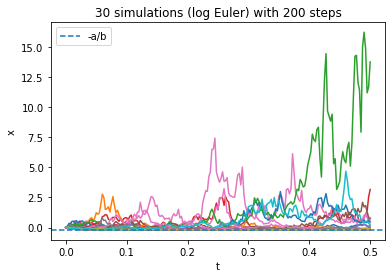

In [360]:
#trajectories test
T0 = 0.5
delta = np.linspace(0,T0,N+1)
nb_simulations = 30
plt.figure()

for j in range(nb_simulations):
    logEuler_curve = [0]
    (u,x,y) =(np.log(a/b),0,0)
    Z = np.random.standard_normal(N)
    C = b*lmbda
    for i in range(N):
        delta_i = delta[i+1]-delta[i]
        sigma_i = lmbda*(a+b*x)
        u = u + (C*(y-chi*x)/sigma_i -0.5*C**2) * delta_i + C * math.sqrt(delta_i) * Z[i]
        y = y + (sigma_i**2 -2*chi*y)*delta_i
        x = np.exp(u) - a/b
        logEuler_curve.append(x)
    plt.plot(delta,logEuler_curve)

plt.axhline(y= -a/b ,linestyle='--',label="-a/b")
plt.legend()
plt.xlabel('t')
plt.ylabel('x')
plt.title(str(nb_simulations) + " simulations (log Euler) with " + str(N) + " steps" )
plt.show()

## Euler

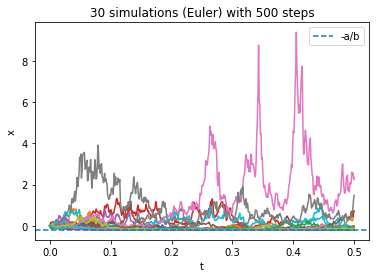

In [345]:
for j in range(nb_simulations):
    Euler_curve = [0]
    (x,y) =(0,0)
    Z = np.random.standard_normal(N)
    for i in range(N):
        delta_i = delta[i+1]-delta[i]
        sigma_i = lmbda*(a+b*x)
        x = x +(y-chi*x)*delta_i + sigma_i*math.sqrt(delta_i)*Z[i]
        y = y + (sigma_i**2 -2*chi*y)*delta_i
        Euler_curve.append(x)
    plt.plot(delta,Euler_curve)

plt.axhline(y= -a/b ,linestyle='--',label="-a/b")
plt.legend()
plt.xlabel('t')
plt.ylabel('x')
plt.title(str(nb_simulations) + " simulations (Euler) with " + str(N) + " steps" )
plt.show()

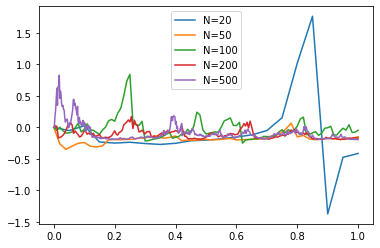

In [141]:
T0 = 1
N_vals = [20,50,100,200,500]
for n in N_vals:
    Euler_curve = [0]
    (x,y) =(0,0)
    Z = np.random.standard_normal(n)
    delta = np.linspace(0,T0,n+1)
    for i in range(n):
        delta_i = delta[i+1]-delta[i]
        sigma_i = lmbda*(a+b*x)
        x = x +(y-chi*x)*delta_i + sigma_i*math.sqrt(delta_i)*Z[i]
        y = y + (sigma_i**2 -2*chi*y)*delta_i
        Euler_curve.append(x)
    plt.plot(delta,Euler_curve,label="N="+str(n))
plt.legend()
plt.show()

## Implicit Euler

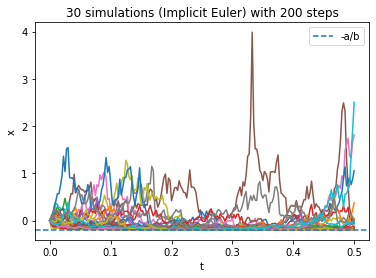

In [361]:
for j in range(nb_simulations):
    Impli_Euler_curve = [0]
    (x,y,I) =(0,0,0)
    Z = np.random.standard_normal(N)
    for i in range(N):
        delta_i = delta[i+1]-delta[i]
        sigma_i = lmbda*(a+b*x)
        I = I - x*delta_i
        y = y + (sigma_i**2 -2*chi*y)*delta_i
        x = (x + y*delta_i + sigma_i*math.sqrt(delta_i)*Z[i])/(1 + chi * delta_i)
        Impli_Euler_curve.append(x)
    plt.plot(delta,Impli_Euler_curve)
    
plt.axhline(y= -a/b ,linestyle='--',label="-a/b")
plt.legend()
plt.xlabel('t')
plt.ylabel('x')
plt.title(str(nb_simulations) + " simulations (Implicit Euler) with " + str(N) + " steps" )
plt.show()

### Euler scheme under terminal measure

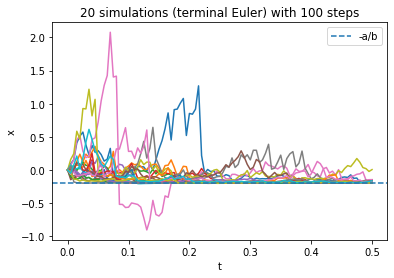

In [16]:
def G(t,T,chi):
    return (1-np.exp(chi*(t-T)))/chi

nb_simulations = 20
delta = T0/N
time = np.linspace(0,T0,N+1)
for j in range(nb_simulations):
    terminal_Euler = [0]
    (x,y,I) =(0,0,0)
    Z = np.random.standard_normal(N)
    for i in range(N):
        sigma_i = lmbda*(a+b*x)
        I = I - x*delta
        x = x + (y - G(i*delta,TN,chi)*sigma_i**2 - chi*x) * delta + sigma_i * math.sqrt(delta)*Z[i]
        y = y + (sigma_i**2 -2*chi*y)*delta
        terminal_Euler.append(x)
    plt.plot(time,terminal_Euler)
plt.axhline(y= -a/b ,linestyle='--',label="-a/b")
plt.legend()
plt.xlabel('t')
plt.ylabel('x')
plt.title(str(nb_simulations) + " simulations (terminal Euler) with " + str(N) + " steps" )
plt.show()

### An other dynamic of x

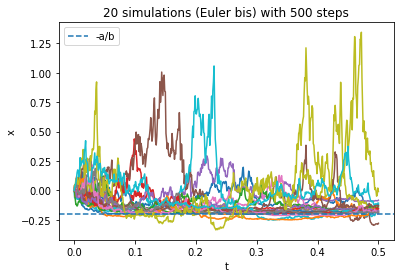

In [326]:
# An other Euler scheme  for x
T0 = 0.5
delta = T0/N
nb_simulations = 20
plt.figure()

for j in range(nb_simulations):
    Euler_curve_bis = [0]
    (x,y,I) =(0,0,0)
    Z = np.random.standard_normal(N)
    W = 0
    for i in range(N):
        X = np.exp((chi + 0.5*b**2)*i*delta - b* np.sqrt(delta) * W)
        x = x + (a/b + I) * (-chi*delta + b* np.sqrt(delta) * Z[i])/X + delta * (a*chi/b + y)
        I = I + delta * (a*chi/b + y) * X
        y = y + ((lmbda*(a+b*x))**2 -2*chi*y)*delta
        W = W + Z[i]
        Euler_curve_bis.append(x)
    plt.plot(np.linspace(0,T0,N+1),Euler_curve_bis)

plt.axhline(y= -a/b ,linestyle='--',label="-a/b")
plt.legend()
plt.xlabel('t')
plt.ylabel('x')
plt.title(str(nb_simulations) + " simulations (Euler bis) with " + str(N) + " steps" )
plt.show()

### Artificially Bounded Euler

In [168]:
import sys
MAX = sys.float_info.max

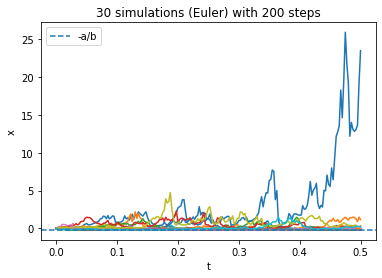

In [367]:
time = np.linspace(0,T0,N+1)
delta = T0/N
for j in range(nb_simulations):
    Euler_curve = [0]
    (x,y,I) =(0,0,0)
    Z = np.random.standard_normal(N)
    for i in range(N):
        sigma_i = lmbda*(a+b*x)
        I = I - x*delta
        if(x + (y-chi*x)*delta + sigma_i*math.sqrt(delta)*Z[i] > 1e10):
            x = 1e10
        else:
            x = x + (y-chi*x)*delta + sigma_i*math.sqrt(delta)*Z[i]
        y = y + (sigma_i**2 -2*chi*y)*delta
        Euler_curve.append(x)
    plt.plot(time,Euler_curve)

plt.axhline(y= -a/b ,linestyle='--',label="-a/b")
plt.legend()
plt.xlabel('t')
plt.ylabel('x')
plt.title(str(nb_simulations) + " simulations (Euler) with " + str(N) + " steps" )
plt.show()